In [1]:
!pip install transformers
!pip install sentencepiece
!pip install datasets
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/MyDrive/multilingual-qa-bias/

     |████████████████████████████████| 4.2 MB 9.9 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 14.0 MB/s 
     |████████████████████████████████| 342 kB 13.8 MB/s 
     |████████████████████████████████| 1.1 MB 75.6 MB/s 
     |████████████████████████████████| 136 kB 64.9 MB/s 
     |████████████████████████████████| 212 kB 79.4 MB/s 
     |████████████████████████████████| 127 kB 91.6 MB/s 
     |████████████████████████████████| 271 kB 82.0 MB/s 
     |████████████████████████████████| 144 kB 74.1 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urlli

In [3]:
# from transformers import MT5ForConditionalGeneration, AutoTokenizer
# import torch
import json
import re
import jieba
from collections import defaultdict
import tqdm
import unicodedata
import pandas as pd
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("Narrativa/mT5-base-finetuned-tydiQA-xqa")
model = MT5ForConditionalGeneration.from_pretrained("Narrativa/mT5-base-finetuned-tydiQA-xqa").to(device)

def get_response(question, context, max_length=32):
  input_text = 'question: %s  context: %s' % (question, context)
  features = tokenizer([input_text], return_tensors='pt')

  output = model.generate(input_ids=features['input_ids'].to(device), 
               attention_mask=features['attention_mask'].to(device),
               max_length=max_length)

  return tokenizer.decode(output[0], skip_special_tokens=True)
  
# Some examples in different languages

Downloading:   0%|          | 0.00/408 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.94M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

In [ ]:
def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the|le|la|l'|les|une|un|des)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    punc = ['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po']
    return "".join(ch for ch in text if unicodedata.category(ch) not in punc)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
  return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth, language):
  pred_tokens = normalize_text(prediction)
  truth_tokens = normalize_text(truth)
  if language == 'zh':
    pred_tokens = list(jieba.cut_for_search(pred_tokens))
    truth_tokens = list(jieba.cut_for_search(truth_tokens))
  else:
    pred_tokens = pred_tokens.split()
    truth_tokens = truth_tokens.split()
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise

  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
    
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
    
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)



In [ ]:
# xor_dev_dpr_retrieval_xlingual_samples.json

with open("./mDPR/xor_dev_dpr_retrieval_xlingual_samples_top1000_final.json") as f:
  xlingual_samples = json.load(f)

In [ ]:
xlingual_samples[1]

[{'answers': ['ఇంగ్లాండ్', 'భారత ఉపఖండం'],
  'context': {'ctx_lang': 'te',
   'has_answer': False,
   'id': '30739502',
   'score': '39.741467',
   'text': 'దేవి అలతారం కోలహలమ్మ కోలాహలమ్మ పేరుతో ఇక్కడ కొల్హాపురం నిర్మిచాడు. కోలహలమ్మ దేవత పూరుతో ఈ నగరం నిర్మించబడిందని ప్రాంతీయ కథనాలు వివరిస్తున్నాయి. చోళపాలకులు వీరరాజేంద్ర చోళుడు (వీరచోళుడు), విక్రమచోళుడు మరియు రాజేంద్రచోళుడు (రాజరాజనరేంద్రచోళుడు) స్థాపించిన శిల్పాలలో మొదటి అవని కోలార్, ముల్బగల్, సిట్టి బెట్టా మరియు ఇతర ప్రాంతాల కొన్ని శిలాక్షరరూప వివరాలు లభిస్తున్నాయి. ఈ శిలాక్షరాలు కోలార్\u200cను " నికరిలి చోళమండలం, జయం కొండ చోళమండలం అని ప్రస్తావిస్తున్నాయి. మొదటి రాజేంద్రచోళుడు కూడా కొలరమ్మ ఆలయం సందర్శించాడు. చోళుల కాలంలో మారికుప్పం గ్రామంలో ఉన్న సోమేశ్వరాలయం, శ్రీ ఉద్దండేశ్వరాలయం, ఉరుగంపేట్\u200cలో ఈశ్వరాలయం, మదివాల గ్రామంలో శివాలయం మొదలైన పలు శివాలయాలు కూడా నిర్మించబడ్డాయి. కోలార్\u200cలో క్రీ.శ 1116 వరకు చోళులపాలన కొనసాగింది. దురదృష్టకరంగా కోలార్ లోని చోళుల శిలాశాసనాలు నిర్లక్ష్యానికి గురైయాయి. కొన్ని సాంస్కృతిక దౌర్జన్యానికి గురయ

In [ ]:
def parse_example(q):
  return {'question': q['question'], 'context':q['context']['text'], 'answers':q['answers'], 'lang':q['lang'], 'source_lang': q['orig_lang'], 'score':q['context']['score']}

def get_em_f1(q, output_answer = False):
  q = parse_example(q)
  # xlingual_samples[1][0]
  pred_answer = get_response(q['question'], q['context'])
  q['pred_answer'] = pred_answer
  # print(q['answers'], pred_answer)
  em_score = []
  f1_score = []
  for ans in q['answers']:
    em_score.append(compute_exact_match(pred_answer, ans))
    f1_score.append(compute_f1(pred_answer, ans, q['lang']))
  if output_answer:
    return max(em_score), max(f1_score), q['lang'],q['score'], q
  else:
    return max(em_score), max(f1_score), q['lang'],q['score']

In [ ]:
langs = list(set([parse_example(q)['lang'] for s in xlingual_samples for q in s ]))
langs

['sl',
 'it',
 'te',
 'th',
 'es',
 'en',
 'pl',
 'ar',
 'ro',
 'bn',
 'bg',
 'gu',
 'cy',
 'ca',
 'nl',
 'tl',
 'hr',
 'sv',
 'vi',
 'af',
 'da',
 'sq',
 'ta',
 'mr',
 'sk',
 'sw',
 'et',
 'el',
 'cs',
 'de',
 'fi',
 'so',
 'ru',
 'lv',
 'fa',
 'zh',
 'id',
 'ko',
 'pt',
 'hi',
 'no',
 'tr',
 'ja',
 'hu',
 'fr',
 'lt']

In [ ]:
em_vecs = []
f1_vecs = []
answers_lst = []
for s in tqdm.tqdm(xlingual_samples):
  answers = {l: -1 for l in langs}
  em_vec={l: -1 for l in langs}
  f1_vec={l: -1 for l in langs}
  scores = {l: -1 for l in langs}
  for q in s:
    if scores[parse_example(q)['lang']] > float(parse_example(q)['score']): continue
    em_score, f1_score, l, score, answer = get_em_f1(q, True)
    em_vec[l] = em_score
    f1_vec[l] = f1_score
    scores[l] = float(score)
    answers[l] = answer
  em_vecs.append(em_vec)
  f1_vecs.append(f1_vec)
  answers_lst.append(answers)
em_vecs, f1_vecs

In [ ]:
with open('em_vecs_1000','w') as f:
  f.write(json.dumps(em_vecs))
with open('f1_vecs_1000','w') as f:
  f.write(json.dumps(f1_vecs))
with open('answers_lst_1000','w') as f:
  f.write(json.dumps(answers_lst))

In [ ]:
with open('em_vecs','w') as f:
  f.write(json.dumps(em_vecs))
with open('f1_vecs','w') as f:
  f.write(json.dumps(f1_vecs))

In [ ]:
with open('answers_lst','w') as f:
  f.write(json.dumps(answers_lst))

# output csv

In [4]:
with open('answers_lst_1000','r') as f:
  # f.write(json.dumps(answers_lst))
  answer_lst = json.load(f)

In [5]:
answer_lst[0]

{'af': -1,
 'ar': -1,
 'bg': -1,
 'bn': -1,
 'ca': -1,
 'cs': -1,
 'cy': -1,
 'da': -1,
 'de': -1,
 'el': -1,
 'en': {'answers': ['Portland'],
  'context': 'Dunedin ( ; ) is the second-largest city in the South Island of New Zealand, and the principal city of the Otago region. Its name comes from , the Scottish Gaelic name for Edinburgh, the capital of Scotland. The urban area of Dunedin lies on the central-eastern coast of Otago, surrounding the head of Otago Harbour, and the harbour and hills around Dunedin are the remnants of an extinct volcano. The city suburbs extend out into the surrounding valleys and hills, onto the isthmus of the Otago Peninsula, and along the shores of the Otago Harbour and the Pacific Ocean.',
  'lang': 'en',
  'pred_answer': 'Dunedin',
  'question': 'What is the largest city in the state of Oregon?',
  'score': '36.527',
  'source_lang': 'te'},
 'es': {'answers': ['Portland'],
  'context': 'Ubon Ratchathani (: , pronunciado ) es uno de las cuatro ciudades i

In [6]:
indicies = random.sample(range(1000), 80)
i = 0
for k in range(len(answer_lst)):
  print(i)
  if int(k) in indicies:
    s = {k:v for k,v in answer_lst[k].items() if v is not -1}
    pd.DataFrame(s).to_csv("./data/predict answers 1000/{}.csv".format(i))
    i+= 1

流式输出内容被截断，只能显示最后 5000 行内容。
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
4
5
5
5
6
6
6
6
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
19
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
24
25
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
26
26
26
26
27
28
28
28
28
28
28
28
28
28
28
29
29
29
29
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31

In [ ]:
import seaborn
import matplotlib.pyplot as plt
seaborn.set(rc={'figure.figsize':(18,18)})
seaborn.set(font_scale=2)

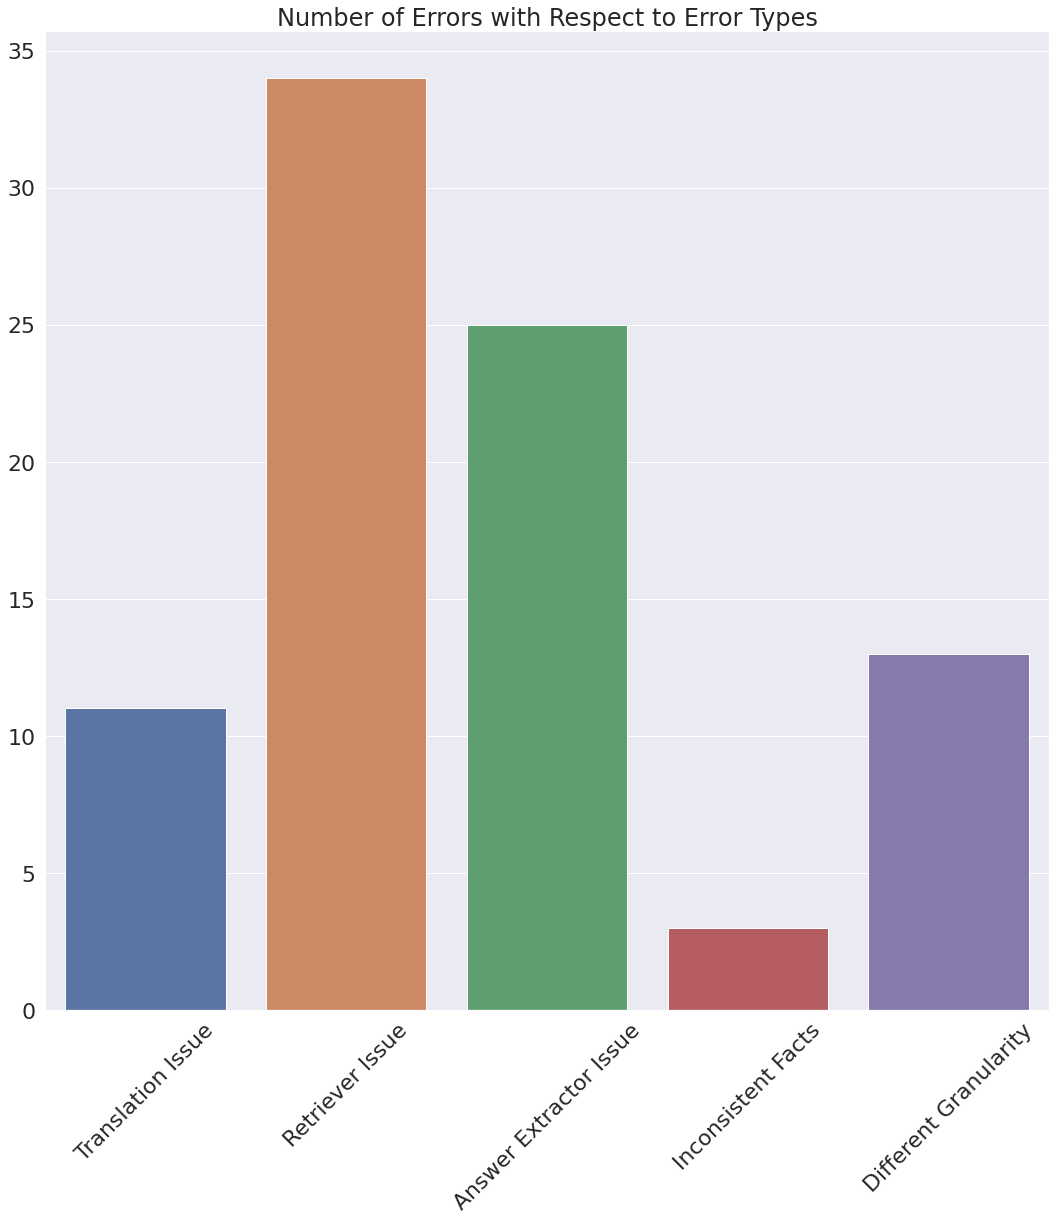

In [ ]:
error_type = ['Translation Issue', 'Retriever Issue', 'Answer Extractor Issue', 'Inconsistent Facts', 'Different Granularity']
error_count = [11, 34, 25, 3, 13]
plot=seaborn.barplot(x = error_type, y = error_count)
plot.set_title("Number of Errors with Respect to Error Types")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.savefig('error graph.png')

In [ ]:
plot=sns.barplot(data=df,  x=" ", y=" ")
plt.setp(plot.get_xticklabels(), rotation=90)